In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

# Prepare a synthesis dataset

In [2]:
INPUT_SIZE = 10000

In [3]:
SEQ_LEN = 8
inputs = torch.rand((INPUT_SIZE, SEQ_LEN))
display(inputs)
print(f'input shape: {inputs.shape}')

tensor([[0.0396, 0.5288, 0.6404,  ..., 0.6606, 0.3656, 0.4164],
        [0.3959, 0.9261, 0.6063,  ..., 0.8144, 0.0909, 0.5241],
        [0.2511, 0.9124, 0.3685,  ..., 0.9922, 0.3354, 0.3649],
        ...,
        [0.9113, 0.9403, 0.9050,  ..., 0.2598, 0.9585, 0.5711],
        [0.0700, 0.3020, 0.1705,  ..., 0.9019, 0.6353, 0.7448],
        [0.2294, 0.1872, 0.3880,  ..., 0.9503, 0.7611, 0.6281]])

input shape: torch.Size([10000, 8])


In [4]:
N_CONTEXTS = 5
context = torch.randint(
    low=0, high=N_CONTEXTS, size=(INPUT_SIZE, 1)
)
display(context)
print(f'context shape: {context.shape}')

tensor([[1],
        [3],
        [3],
        ...,
        [4],
        [4],
        [4]])

context shape: torch.Size([10000, 1])


For if the context of the i-th observation is $c_i$, then the ground true is: $outputs^{(i)} = inputs^{(i)}[\text{true_attention}[c_i]]$

In [5]:
true_attention = {
    0:2,
    1:7,
    2:3,
    3:5,
    4:1
}
true_attention

{0: 2, 1: 7, 2: 3, 3: 5, 4: 1}

In [6]:
outputs = torch.tensor([
    inputs[i, true_attention[context[i].item()]] 
    for i in range(INPUT_SIZE)
])
display(outputs)
print(f'output shape: {outputs.shape}')

tensor([0.4164, 0.8144, 0.9922,  ..., 0.9403, 0.3020, 0.1872])

output shape: torch.Size([10000])


# Train an Attention network

In [7]:
class AttentionNetwork(nn.Module):
    def __init__(self):
        super(AttentionNetwork, self).__init__()
        self.context_embed = nn.Embedding(N_CONTEXTS, SEQ_LEN)
        self.linear = nn.Linear(SEQ_LEN, 1)
    
    def forward(self, x, c): # x is input (feature), c is context
        a = self.context_embed(c)
        x = x * a # element-wise multiplication
        x = self.linear(x)
        return x
    
    def get_attention(self, c):
        a = self.context_embed(c)
        return a

model = AttentionNetwork()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [8]:
model.train()
for epoch in range(4):
    losses = []
    for i in tqdm(range(INPUT_SIZE)):
        inp = inputs[i]
        c = context[i]

        optimizer.zero_grad()
        pred = model(inp, c).squeeze()
        loss = criterion(pred, outputs[i])
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    print(f'epoch {epoch}: MSE = {np.mean(losses):.7f}')

  4%|▍         | 409/10000 [00:00<00:04, 2053.81it/s]

epoch 0: MSE = 0.0529509


  2%|▏         | 178/10000 [00:00<00:05, 1776.37it/s]

epoch 1: MSE = 0.0029285


  2%|▏         | 205/10000 [00:00<00:04, 2043.52it/s]

epoch 2: MSE = 0.0000126


100%|██████████| 10000/10000 [00:05<00:00, 1992.96it/s]

epoch 3: MSE = 0.0000125


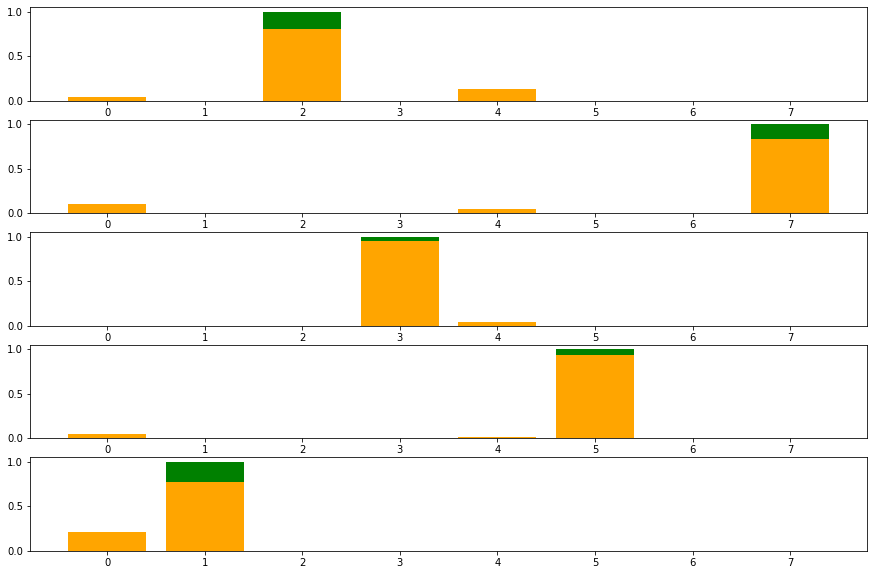

In [9]:
model.eval()
fig, ax = plt.subplots(N_CONTEXTS, figsize=(15, 10))
for c in range(N_CONTEXTS):
    true_att_index = np.zeros(SEQ_LEN)
    true_att_index[true_attention[c]] = 1
    ax[c].bar(range(SEQ_LEN),true_att_index, color='green')
    
    computed_attention = model.get_attention(torch.tensor(c)).detach().abs()
    computed_attention /= computed_attention.sum()
    ax[c].bar(range(SEQ_LEN), computed_attention, color='orange')